In [19]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models

In [3]:
ROOT_DIR = 'yolostyle'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
test_imgs_dir = 'test/images'
test_labels_dir = 'test/labels'

classes = ['Ascaris lumbricoides', 'Capillaria philippinensis','Enterobius vermicularis','Fasciolopsis buski','Hookworm egg',
'Hymenolepis diminuta','Hymenolepis nana','Opisthorchis viverrine','Paragonimus spp','Taenia spp. egg','Trichuris trichiura']
 
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [4]:
EPOCHS = 25
BATCH_SIZE = 16
WORKERS = 8

In [5]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Indexing dataset annotations: 100%|█████████████████████████████████████████████████▊| 199/200 [00:03<00:00, 57.67it/s]

Indexing dataset annotations: 100%|██████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.63it/s]


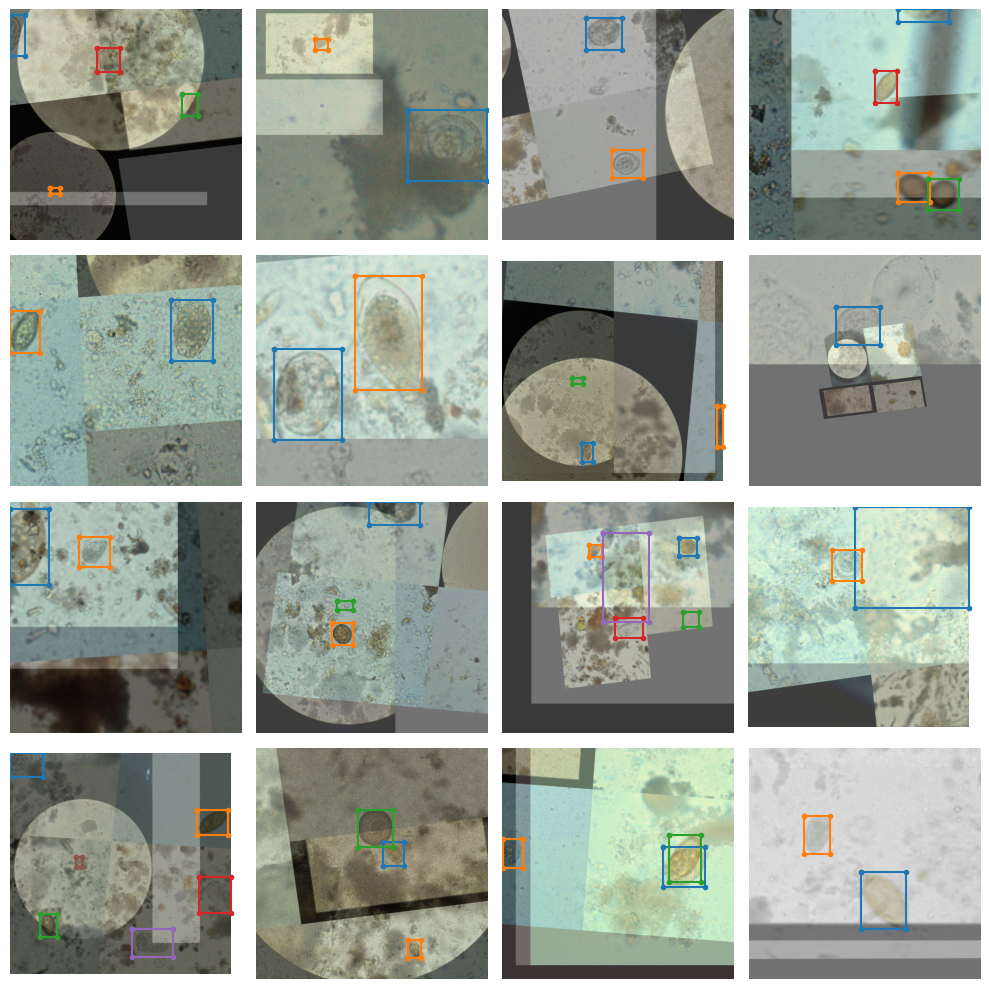

In [5]:
train_data.dataset.plot()

In [5]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

Reusing TensorBoard on port 6006 (pid 16064), started 4 days, 10:31:59 ago. (Use '!kill 16064' to kill it.)

In [6]:
train_params = {
    'silent_mode': False,
    "average_best_models":False,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": False,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [7]:
model_to_train = 'yolo_nas_m'
CHECKPOINT_DIR = 'checkpoints_parasite_eggs'
 
trainer = Trainer(
    experiment_name=model_to_train, 
    ckpt_root_dir=CHECKPOINT_DIR)

model = models.get(
     model_to_train, 
     num_classes=len(dataset_params['classes']),
     checkpoint_path=r'H:\Repo\Track\checkpoints_parasite_eggs\yolo_nas_m\RUN_20231027_090633_427945\ckpt_latest.pth')

Indexing dataset annotations: 100%|██████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.79it/s]


In [ ]:
trainer.train(
     model=model, 
     training_params=train_params, 
     train_loader=train_data,
     valid_loader=val_data)

Train epoch 0: 100%|██████████| 110/110 [53:26<00:00, 29.15s/it, PPYoloELoss/loss=1.47, PPYoloELoss/loss_cls=0.742, PPY
Validating: 100%|██████████| 28/28 [05:26<00:00, 11.66s/it]
Train epoch 1: 100%|██████████| 110/110 [56:58<00:00, 31.08s/it, PPYoloELoss/loss=1.47, PPYoloELoss/loss_cls=0.751, PPY
Validating epoch 1: 100%|██████████| 28/28 [05:16<00:00, 11.30s/it]
Train epoch 2: 100%|██████████| 110/110 [57:32<00:00, 31.39s/it, PPYoloELoss/loss=1.5, PPYoloELoss/loss_cls=0.771, PPYo
Validating epoch 2: 100%|██████████| 28/28 [05:14<00:00, 11.22s/it]
Train epoch 3: 100%|██████████| 110/110 [56:28<00:00, 30.80s/it, PPYoloELoss/loss=1.56, PPYoloELoss/loss_cls=0.803, PPY
Validating epoch 3: 100%|██████████| 28/28 [05:13<00:00, 11.20s/it]
Train epoch 4: 100%|██████████| 110/110 [54:12<00:00, 29.57s/it, PPYoloELoss/loss=1.54, PPYoloELoss/loss_cls=0.795, PPY
Validating epoch 4: 100%|██████████| 28/28 [05:03<00:00, 10.86s/it]
Train epoch 5: 100%|██████████| 110/110 [55:18<00:00, 30.17s/it, PPY

In [8]:
best_model = models.get('yolo_nas_m',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=r'H:\Repo\Track\checkpoints_parasite_eggs\yolo_nas_m\RUN_20231027_090633_427945\ckpt_best.pth')

In [10]:
trainer.test(
model=best_model,
test_loader=test_data,
test_metrics_list=DetectionMetrics_050(
score_thres=0.5,
top_k_predictions=300,
num_cls=len(dataset_params['classes']),
normalize_targets=True,
post_prediction_callback=PPYoloEPostPredictionCallback(
score_threshold=0.01,
nms_top_k=1000,
max_predictions=300,
nms_threshold=0.7
)
)
)

Testing: 100%|██████████| 13/13 [02:37<00:00,  7.63s/it]

{'Precision@0.50': 0.6945328116416931,
 'Recall@0.50': 0.5313964486122131,
 'mAP@0.50': 0.59194415807724,
 'F1@0.50': 0.5497226119041443}

Testing: 100%|██████████| 13/13 [02:38<00:00, 12.17s/it]


In [33]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=r"H:\Repo\parasite-eggs\yolostyle\test\images",
    annotations_directory_path=r"H:\Repo\parasite-eggs\yolostyle\test\labels",
    data_yaml_path=r"H:\Repo\parasite-eggs\yolostyle\test\data.yaml",
    force_masks=False
)

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

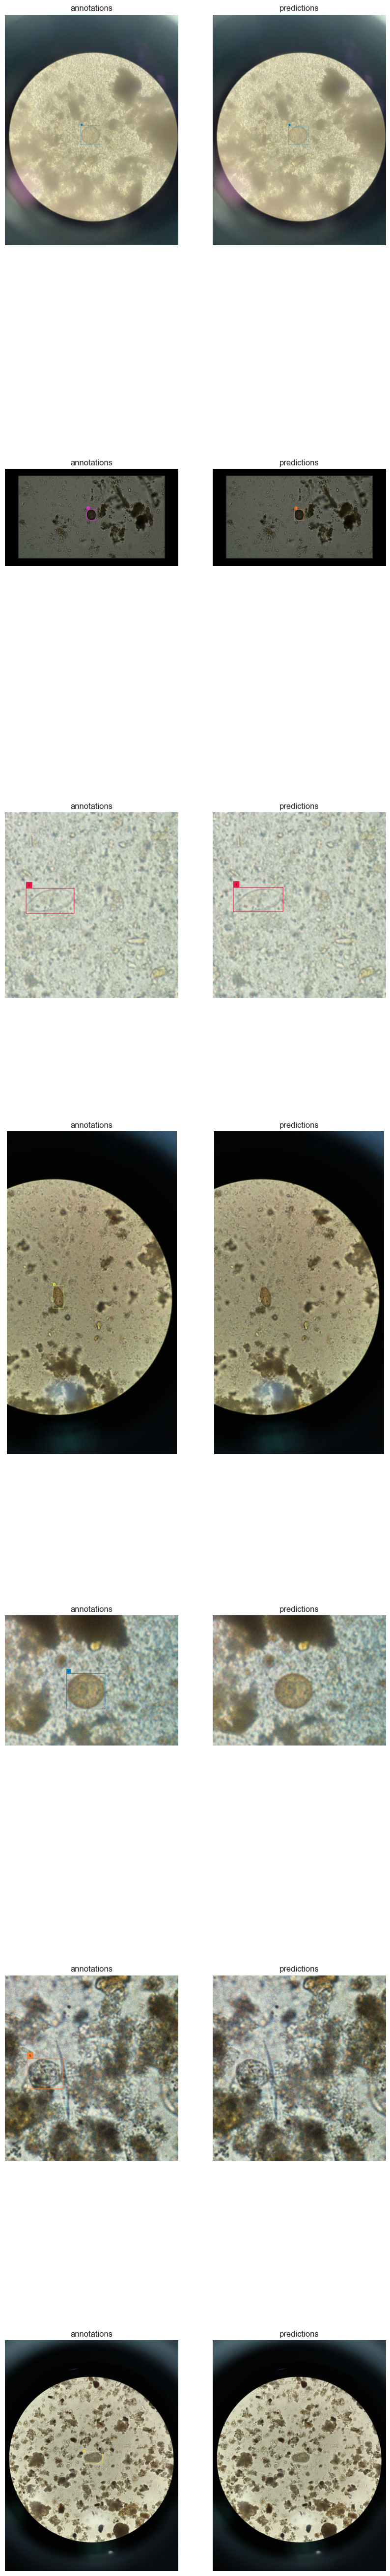

In [34]:
import random

random.seed(3)
MAX_IMAGE_COUNT = 7
n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=False
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=False
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 5, n * 10))

In [26]:
!pip install onemetric

In [30]:
from onemetric.cv.object_detection import ConfusionMatrix
import os
import numpy as np

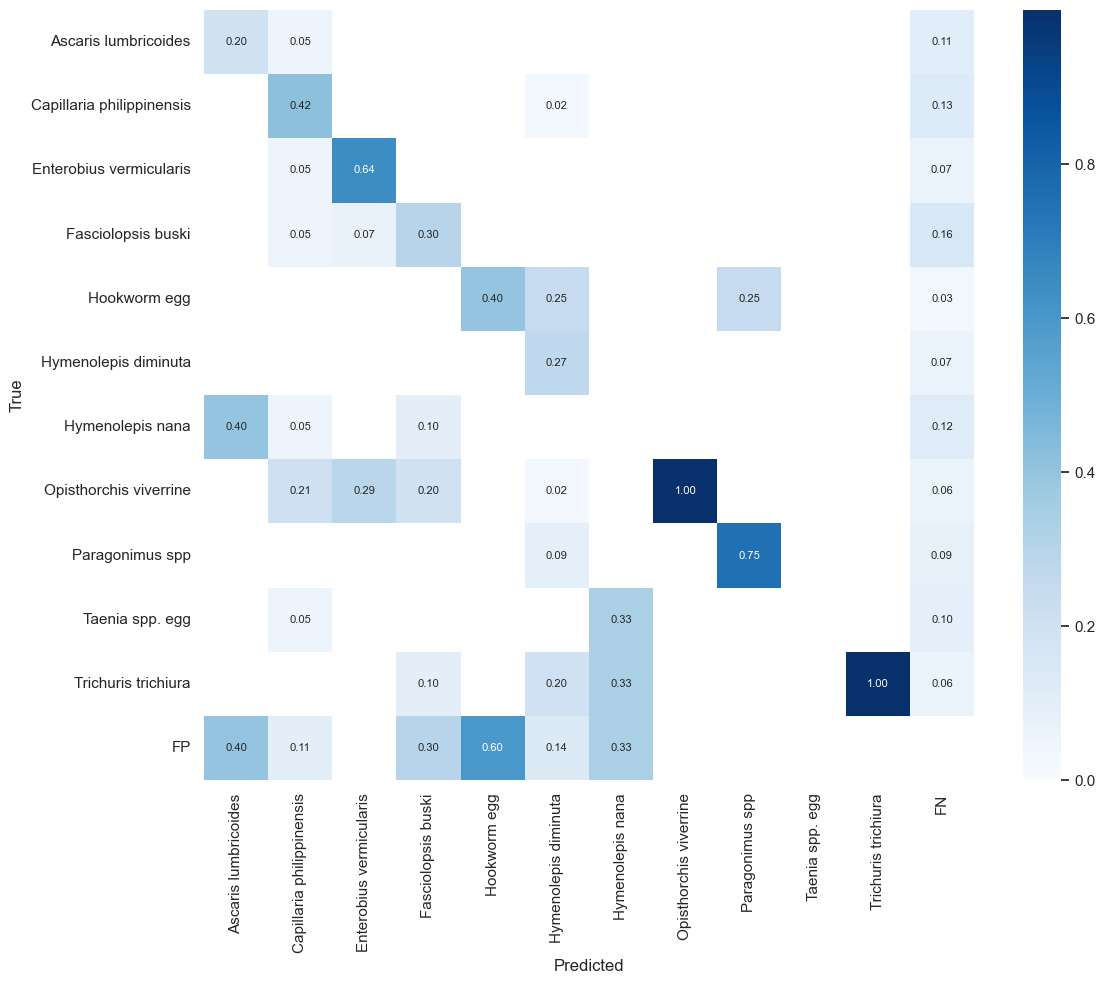

In [35]:
keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(r'H:\Repo\Track', "confusion_matrix.png"), class_names=ds.classes)